In [1]:
from source import Dataset
from source import tools
import awkward as ak
import glob
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-12-05 18:27:10.529868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 18:27:10.645414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-05 18:27:10.645447: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-05 18:27:12.209357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
#selecting features 
branches_to_train = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ", 
"cscRechitClusterSize"
]

#energy key
truth_value = "cscRechitCluster_match_gLLP_e"

In [3]:
branches_to_train

['cscRechitClusterX',
 'cscRechitClusterY',
 'cscRechitClusterZ',
 'cscRechitClusterTimeWeighted',
 'cscRechitClusterTimeSpreadWeightedAll',
 'cscRechitClusternXY',
 'cscRechitClusternZ',
 'cscRechitClusterXSpread',
 'cscRechitClusterYSpread',
 'cscRechitClusterZSpread',
 'cscRechitClusterXYSpread',
 'cscRechitClusterRSpread',
 'cscRechitClusterEtaPhiSpread',
 'cscRechitClusterEtaSpread',
 'cscRechitClusterPhiSpread',
 'cscRechitClusterDeltaRSpread',
 'cscRechitClusterMajorAxis',
 'cscRechitClusterMinorAxis',
 'cscRechitClusterSkewX',
 'cscRechitClusterSkewY',
 'cscRechitClusterSkewZ',
 'cscRechitClusterKurtX',
 'cscRechitClusterKurtY',
 'cscRechitClusterKurtZ',
 'cscRechitClusterSize']

In [4]:
#read data
dataset_signal = Dataset.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5")

Opening file  /nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5


In [5]:
#cut clusters which don't have LLP
olen = len(df_signal)
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]
print('cut out ' + str(olen - len(df_signal)) + ' clusters, which leaves ' + str(len(df_signal)) + ' clusters containing a LLP decay for training')

cut out 10236 clusters, which leaves 79780 clusters containing a LLP decay for training


In [6]:
# Splitting the data into train, val, test
train_data, testval_data = train_test_split(df_signal, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

# assigning labels (true energy values)
train_labels = np.array(train_data[truth_value])#([1.]*len(train_data))
test_labels = np.array(test_data[truth_value])#([1.]*len(test_data))
val_labels = np.array(val_data[truth_value])#([1.]*len(val_data))

# select only branches we want
train_data = train_data[branches_to_train]
test_data = test_data[branches_to_train]
val_data = val_data[branches_to_train]

# check the shape
print(" signal training features", train_data.shape,
    "\n signal training labels", train_labels.shape,
    "\n signal test features", test_data.shape,
    "\n ignal test labels", test_labels.shape,
    "\n signal val features", val_data.shape,
    "\n signal val labels", val_labels.shape)

 signal training features (47868, 25) 
 signal training labels (47868,) 
 signal test features (15956, 25) 
 ignal test labels (15956,) 
 signal val features (15956, 25) 
 signal val labels (15956,)


In [7]:
# see what training data looks like
print(train_labels)
print(train_data)

# store number of features for input shape
n_features = train_data.shape[1]

[217.19367981 100.89956665  92.29994202 ... 229.31735229 525.51751709
 131.0032959 ]
       cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
61427          37.355038        -369.166840        -942.384888   
67122         382.418976        -480.266296       -1037.592651   
35019        -159.620148         159.803024         604.080933   
50622        -366.879730        -209.248169         805.633606   
10355         343.619141          -6.701683         711.530029   
...                  ...                ...                ...   
52097         190.122833         589.566650        1037.569946   
78466          12.762341        -189.099884        -596.863403   
5377          299.280396         -32.023300        1027.092896   
67209         -78.838432         -93.476219         600.861206   
1488          184.990143        -353.791046         839.464905   

       cscRechitClusterTimeWeighted  cscRechitClusterTim

In [8]:
#defining the model and metrics
METRICS = [
      keras.metrics.MeanSquaredError(name='Brier score'),
]


def make_model(metrics=METRICS, output_bias=None, layers = [50, 30, 20, 5, 1], n_input = n_features):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    #initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=200, seed=None)
    initializer = tf.keras.initializers.Constant(value=100)
    
    model = keras.Sequential(keras.layers.Dense(layers[0], activation = 'relu', input_shape = (n_input,)))

    
    for nodes in layers[1:]:
        model.add(keras.layers.Dense(nodes, activation = 'relu'))
    

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=1e-3),
        loss = keras.losses.MeanSquaredError(name='MSE'),
        metrics = metrics
    )
    
    return model

In [9]:
# prerequesites

X_train, Y_train = sklearn.utils.shuffle(train_data, train_labels, random_state=0) # change to random_state=None for full randomness
X_test, Y_test = sklearn.utils.shuffle(test_data, test_labels, random_state=0) # change to random_state=None for full randomness
X_val, Y_val = sklearn.utils.shuffle(val_data, val_labels, random_state=0) # change to random_state=None for full randomness

EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #val_prec
    verbose = 1,
    patience = 10,
    mode = 'min',#max
    restore_best_weights = True)

In [18]:
model = make_model()
model.summary()
history = model.fit(
    X_train,
    Y_train,
    batch_size = 100,
    epochs = EPOCHS, #EPOCHS
    callbacks = [early_stopping],
    validation_data = (val_data, val_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                1300      
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 20)                620       
                                                                 
 dense_8 (Dense)             (None, 5)                 105       
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
479/479 [==============================]

Epoch 45/100
479/479 [==============================] - 1s 2ms/step - loss: 4112.1787 - Brier score: 4112.1787 - val_loss: 4512.5220 - val_Brier score: 4512.5220
Epoch 46/100
479/479 [==============================] - 1s 2ms/step - loss: 4108.3970 - Brier score: 4108.3970 - val_loss: 4384.6582 - val_Brier score: 4384.6587
Epoch 47/100
479/479 [==============================] - 1s 2ms/step - loss: 4112.3579 - Brier score: 4112.3579 - val_loss: 4293.6528 - val_Brier score: 4293.6528
Epoch 48/100
479/479 [==============================] - 1s 2ms/step - loss: 4096.6465 - Brier score: 4096.6465 - val_loss: 4303.2949 - val_Brier score: 4303.2949
Epoch 49/100
479/479 [==============================] - 1s 2ms/step - loss: 4084.1738 - Brier score: 4084.1738 - val_loss: 4388.3726 - val_Brier score: 4388.3726
Epoch 50/100
479/479 [==============================] - 1s 2ms/step - loss: 4091.0488 - Brier score: 4091.0488 - val_loss: 4332.3960 - val_Brier score: 4332.3960
Epoch 51/100
479/479 [======

In [24]:
def plot_loss(history):
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(history.epoch, history.history['loss'], label = 'Training', color = 'blue')
    ax.plot(history.epoch, history.history['val_loss'], linestyle = '--', color = 'blue', label = 'Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    
def predict_plot(model = model, test_data = test_data, test_target = test_labels, batches = 1024, axlabels = ('clusters', 'generated particle energy')):
    fig, ax = plt.subplots(figsize = (6, 4))
    
    predictions = model.predict(test_data, batch_size = batches)
    histdata, bins, dummy = ax.hist(test_target, bins = 50, histtype="step", color = 'b', label = 'truth')
    ax.hist(predictions, bins = bins, histtype="step", color = 'r', label = 'predictions')
    ax.set_yscale('log')
    ax.set_ylabel(axlabels[0])
    ax.set_xlabel(axlabels[1])
    ax.legend()
    
def modeltest(layers = [50, 30, 20, 5, 1], leftoutfeatures = [], epochs = 50):
    print('model layers : ', layers, 
         '\nfeatures left out : ', leftoutfeatures,
         '\nepochs : ', epochs)

47/47 [==============================] - 0s 823us/step


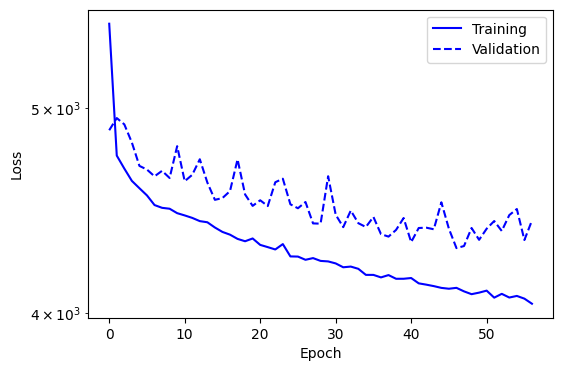

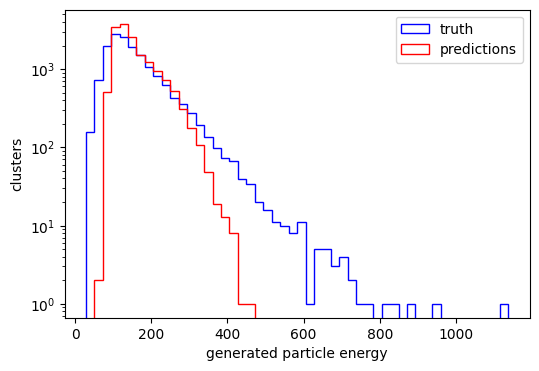

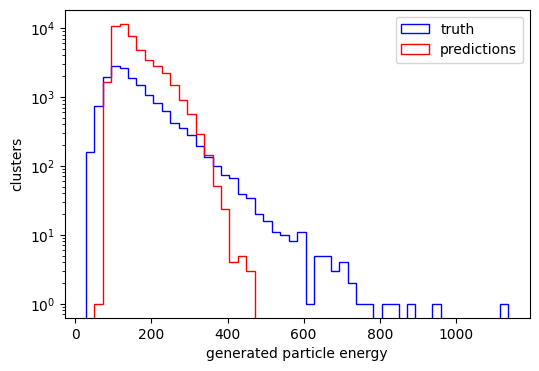

In [26]:
plot_loss(history)
predict_plot()
predict_plot(test_data = train_data)

In [21]:
from source.tools import tools
obj = tools()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [22]:
test_predictions = model.predict(test_data, batch_size=BATCH_SIZE)

16/16 [==============================] - 0s 2ms/step


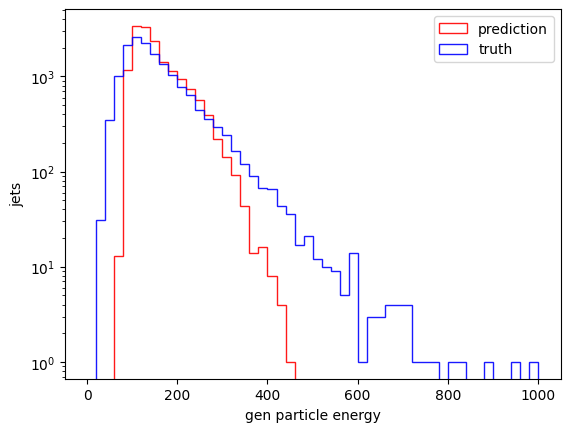

In [23]:
obj = tools()
obj.plotHist(test_predictions,test_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)